In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import itertools
sys.path.append("/mnt/ssd/NMRlipids_VI-NewIonModel/scripts/")
import calcOrderParameters as cop
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
exper_fname = "/mnt/ssd/NMRlipids_VI-NewIonModel/Data/POPC/exp/POPC_Order_Parameters_Experiments_all.dat"

sim_l14_fname = "NpT/sim0_ref_noIons/OrdPars.dat"
sim_ecc_fname1 = "NpT/sim22a_0mM_NaCl_OPC3_non-tail-atoms_q-sc_0.80_sig-sc_0.89_noIons-ref_300K/OrdPars.dat"
sim_ecc_fname2 = "NpT/sim22a_0mM_NaCl_OPC4_non-tail-atoms_q-sc_0.80_sig-sc_0.89_noIons-ref/OrdPars.dat"
sim_ecc_fname3 = "NpT/sim22a_0mM_NaCl_SPCE_non-tail-atoms_q-sc_0.80_sig-sc_0.89_noIons-ref/OrdPars.dat"

fnames = [exper_fname, sim_l14_fname, sim_ecc_fname1] #, sim_ecc_fname2, sim_ecc_fname3] 

models = []
for fname in fnames:
    model = cop.parse_op_input(fname)
    models.append(model)


In [3]:
# define mapping for ordering of my OP labels
def popc_order(s):
    groups = ('gamma', 'beta', 'alpha', '--space--', 'g3', 'g2', 'g1') #, 'palmitoyl', 'oleoyl')
    if not s.startswith(groups):
        return 2*len(groups)
    else:
        for i,g in enumerate(groups):
            if s.startswith(g):
                return 2*i
    
refmodel = models[0]
ax_x_labels = refmodel.keys()
ax_x_labels.sort()
ax_x_labels = sorted(ax_x_labels, key=popc_order)

xlabels = (r'$\gamma$', r'$\beta$', r'$\alpha$', '', r'$g_3$', r'$g_2$', r'$g_1$')

Plotting figure 1

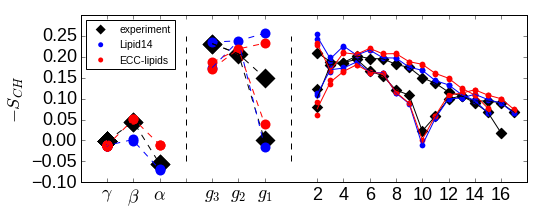

In [4]:
font = {'family' : 'Liberation Sans',
        'style'  : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(nrows=1, ncols=1, sharex="all", figsize=[8,3], dpi=200)
# add some text for labels, title and axes ticks
#ax.set_xlabel(r'POPC Headgroup and tail order parameters')
ax.set_ylabel(r'$-S_{CH}$')
ax.set_xlim([-2,32])
ax.set_ylim([-0.1,0.3])
r1 = range(0, 2*len(xlabels), 2)
r2 = range(2*len(xlabels)+2, 2*len(xlabels)+18, 2)
r1.extend(r2)
ax.set_xticks(r1)
xlabelsl = list(xlabels)
xlabelsl.extend(range(2, 18, 2))
ax.set_xticklabels(xlabelsl, rotation=0)

legends = ['experiment', 'Lipid14', r'ECC-lipids', r'ECC-lipids 17, OPC4', r'ECC-lipids 17, SPC/E'] #, 'scaled Oxy. sigmas 0.90 0mM', 'scaled OCH headgr. sigmas 0.94 0mM',
           #'scaled 0.75 Oxy. sigmas 0.90 0mM', 'scaled 0.75 Oxy. sigmas 0.90 0mM NpAT']
colours = ['black', 'blue',  'red',  '#DE4578',  '#BB5487']  # zip() truncates the to the shortest list

for (model, legend, colour) in zip(models, legends, colours):
    choline_ops = []
    glyc_ops_a = []
    glyc_ops_b = []
    if "exper" in legend:
        point_marker = "D"
        point_size = 200
    else:
        point_marker = "o"
        point_size = 100
    for (i, label) in enumerate(ax_x_labels):
        if i == 0:
            point_label = legend
        else:
            point_label = ""
        if label in model.keys() and not (label.startswith("ole") or label.startswith("palm")):
            ax.scatter(popc_order(label), -float(model[label].avg), marker=point_marker, c=colour, s=point_size, lw=0, label=point_label)
            if label.startswith(('gamma', 'beta', 'alpha')):
                choline_ops.append([popc_order(label), -float(model[label].avg)])
            if label.startswith(('g3', 'g2', 'g1')):
                if label.endswith('_1'):
                    glyc_ops_a.append([popc_order(label), -float(model[label].avg)])
                if label.endswith('_2') or label=='g2_1':
                    glyc_ops_b.append([popc_order(label), -float(model[label].avg)])
        else:
            pass
            #print "Label {lab} not found in current model keys, model: {mod}".format(lab=label, mod=model)
    for ops in [choline_ops, glyc_ops_a, glyc_ops_b]:
        headgr_ops_temp = np.array(ops)
        ax.plot(headgr_ops_temp[:,0], headgr_ops_temp[:,1], c=colour, lw=1.0, label=point_label, ls='dashed')
    
    tails={}
    tails_list={}
    psize_denom = 3
    for tail,chiral,i in itertools.product(['palmitoyl_C', 'oleoyl_C'], ['a', 'b'], range(2, 18)):
        label = tail+str(i)+chiral
        if "exper" in legend:
            point_marker = "D"
            point_size = 200/psize_denom
        else:
            point_marker = "o"
            point_size = 100/psize_denom
        try: 
            ax.scatter(popc_order(label)+i, -float(model[label].avg), marker=point_marker, c=colour, s=point_size, lw=0, label=point_label)
        except:
            pass
            #print "Label {lab} not found in current model keys, model: {mod}".format(lab=label, mod=model)
        if not tail in tails.keys():
            tails[tail] = {}
            tails_list[tail] = []
        if label in model.keys():
            if not i in tails[tail].keys():
                tails[tail][i] = []
            try:
                tails[tail][i].append(float(model[label].avg))
            except:
                pass
                #print "Label {lab} not found in current model keys, model: {mod}".format(lab=label, mod=model)
    for tail in tails.keys():
        for item in tails[tail].items():
            tails_list[tail].append([item[0], np.average(item[1])])
        tail_temp = np.array(tails_list[tail])
        try:
            ax.plot(tail_temp[:,0]+2*len(xlabels), -tail_temp[:,1], c=colour, lw=1.0, ls="-", label=point_label)
        except:
            pass

        
# choline-glycerol separator
ax.vlines(len(xlabels)-1, -0.05, 0.25, linestyles='dashed')
# glycerol-tails separator
ax.vlines(2*len(xlabels), -0.05, 0.25, linestyles='dashed')


ax.legend(loc="upper left", markerscale=0.5, scatterpoints=1, fontsize='xx-small')
plt.savefig("Order-parameters_exp-L14-ECCL17_q80_sig89.pdf", dpi=200, bbox_inches='tight')
plt.show()
